<a href="https://colab.research.google.com/github/soumita-nayna/Learning/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Business Problem
To reduce the number of default payments keeping the approval rate high

### Objective 
To predict whether a future order will be defaulted or not. The whole

### Data Source
Excel file is uploaded in google drive, and accessed directly from google colab

### Execution Platform
[Google colab](https://colab.research.google.com)

##### Contributor: Soumita Saha

##### Date: 2021-08-08

--------------------------------------------------------------------------------

# Importing data to python environment

In [1]:
# Importing the libraries
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
# Connecting with google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Getting the name of different sheets in excel
df = pd.ExcelFile('/content/gdrive/My Drive/orders.xlsx')
print(df.sheet_names)

['orders']


In [4]:
# Reading the content of the excel file in a pandas data frame
df = pd.read_excel('/content/gdrive/My Drive/orders.xlsx', sheet_name = 'orders')

# Data Understanding

In [5]:
# Size of data (number of rows and number of columns)
df.shape

(10000, 15)

In [6]:
# See the top 5 rows from the dataframe
df.head(5)

,order_id,customer_id,merchant_id,order_amount,checkout_started_at,credit_decision_started_at,approved_for_installments,customer_credit_score,customer_age,customer_billing_zip,customer_shipping_zip,paid_installment_1,paid_installment_2,paid_installment_3,paid_installment_4
0,42C39B,9D74A0,6881F9,147.20,2018-10-03 14:26:18.497,2018-10-03 14:26:18.997,True,626,26,95407,95407,1.0,1,1.0,1.0
1,A19AC4,2629AB,C37828,69.95,2018-09-21 16:55:03.443,2018-09-21 16:55:05.100,True,603,20,85007,85007,1.0,1,1.0,1.0
2,381AFF,793FE0,252600000000,45.00,2018-09-15 13:41:46.103,2018-09-15 13:41:47.197,True,648,41,30305-2646,30305-2646,1.0,1,1.0,1.0
3,3184A3,22C696,24FBAF,164.00,2018-10-10 00:59:25.793,2018-10-10 00:59:26.123,True,625,33,28562,28562,1.0,1,1.0,1.0
4,237711,D4E94A,6F498E,69.17,2018-09-12 22:53:08.970,2018-09-12 22:53:10.923,True,438,18,92324,92324,1.0,1,1.0,1.0


In [7]:
# Check the column names and their data type
df.dtypes

order_id                              object
customer_id                           object
merchant_id                           object
order_amount                         float64
checkout_started_at           datetime64[ns]
credit_decision_started_at    datetime64[ns]
approved_for_installments               bool
customer_credit_score                  int64
customer_age                           int64
customer_billing_zip                  object
customer_shipping_zip                 object
paid_installment_1                   float64
paid_installment_2                     int64
paid_installment_3                   float64
paid_installment_4                   float64
dtype: object

In [8]:
# Changing the datatype for objects to string 
for i in df.select_dtypes(['object']).columns:
    df[i] = df[i].astype('str')

In [9]:
# Getting the count of unique values for each column
col_list = df.columns.values
for col in col_list:
  print("Unique values in", col, len(df[col].unique()))

Unique values in order_id 9991
Unique values in customer_id 8932
Unique values in merchant_id 105
Unique values in order_amount 4250
Unique values in checkout_started_at 10000
Unique values in credit_decision_started_at 9993
Unique values in approved_for_installments 1
Unique values in customer_credit_score 448
Unique values in customer_age 66
Unique values in customer_billing_zip 5530
Unique values in customer_shipping_zip 5489
Unique values in paid_installment_1 2
Unique values in paid_installment_2 2
Unique values in paid_installment_3 3
Unique values in paid_installment_4 3


From the above output, we can see that we have 9991 distinct values for order ID, 8932 distinct values for customer ID, 105 distinct values for merchant ID, and so on. We expected the order ID to be unique in the data, but since there are some duplicate values or multiple row for a single order ID, hence we need to investigate it further.


In [10]:
# Finding out which Order ID are duplicated or has multiple rows
test = pd.DataFrame(df["order_id"].value_counts().reset_index())
test.columns = ["value", "cnt"]
test[test["cnt"]>1]

,value,cnt
0,0,6
1,E62664,2
2,5F2B62,2
3,3BE8CD,2
4,7200,2


Now, we will investifate in each of the duplicates.

In [11]:
df[(df['order_id'] == '5F2B62')]

,order_id,customer_id,merchant_id,order_amount,checkout_started_at,credit_decision_started_at,approved_for_installments,customer_credit_score,customer_age,customer_billing_zip,customer_shipping_zip,paid_installment_1,paid_installment_2,paid_installment_3,paid_installment_4
90,5F2B62,756389,26ECA2,63.66,2018-09-09 23:57:07.197,2018-09-09 23:57:08.587,True,693,24,11432,11432,1.0,1,1.0,1.0
6442,5F2B62,5189CD,E3FFE5,301.41,2018-08-31 19:00:54.030,2018-08-31 19:00:55.203,True,596,32,32224,32224,1.0,1,1.0,1.0


Here, both the records seem to be valid, and therefore we will discard the old record based on checkout start timestamp.

In [12]:
df[(df['order_id'] == '3BE8CD')]


,order_id,customer_id,merchant_id,order_amount,checkout_started_at,credit_decision_started_at,approved_for_installments,customer_credit_score,customer_age,customer_billing_zip,customer_shipping_zip,paid_installment_1,paid_installment_2,paid_installment_3,paid_installment_4
302,3BE8CD,8042BB,8D665E,108.00,2018-09-27 18:36:51.503,2018-09-27 18:36:51.970,True,764,30,98126,98126,1.0,1,1.0,1.0
5794,3BE8CD,780000000000000,26ECA2,30.86,2018-10-04 17:56:56.673,2018-10-04 17:56:57.033,True,450,20,10009,10009,1.0,1,1.0,1.0


Here, the second record has an invalid customer ID, therfore discarding that record.

In [13]:
df[(df['order_id'] == 'E62664')]


,order_id,customer_id,merchant_id,order_amount,checkout_started_at,credit_decision_started_at,approved_for_installments,customer_credit_score,customer_age,customer_billing_zip,customer_shipping_zip,paid_installment_1,paid_installment_2,paid_installment_3,paid_installment_4
3762,E62664,1F2937,B8CF53,199.00,2018-09-15 20:31:29.543,2018-09-15 20:31:30.577,True,701,49,19027-2644,19027-2644,1.0,1,1.0,1.0
6119,E62664,A68EE5,6F498E,42.23,2018-09-24 23:11:50.683,2018-09-24 23:11:52.263,True,611,19,21801,21801,1.0,1,1.0,1.0


Here, the first record has an invalid customer zip code, therefore discarding that record.

In [14]:
df[(df['order_id'] == '7200')]


,order_id,customer_id,merchant_id,order_amount,checkout_started_at,credit_decision_started_at,approved_for_installments,customer_credit_score,customer_age,customer_billing_zip,customer_shipping_zip,paid_installment_1,paid_installment_2,paid_installment_3,paid_installment_4
1134,7200,AB49AC,C37828,53.92,2018-09-18 20:05:32.107,2018-09-18 20:05:33.793,True,571,35,23192,23192,1.0,1,1.0,1.0
4629,7200,6C16F5,6881F9,313.60,2018-09-14 15:12:53.983,2018-09-14 15:12:54.953,True,655,35,63461,63461,1.0,1,1.0,1.0


Here, both the records seem to be valid, and therefore we will discard the old record based on checkout start timestamp.

In [15]:
# Dropping duplicate order IDs, and "0" order IDs
df = df.drop(df.index[[6442, 5794, 3762, 4629]])
df = df[df['order_id']!='0']

In [16]:
# Check to see if order ID still has any duplicate records
test = pd.DataFrame(df["order_id"].value_counts().reset_index())
test.columns = ["value", "cnt"]
test[test["cnt"]>1]

,value,cnt


In [17]:
# A quick glimpse to all the integer (or float) variables
df.describe()

,order_amount,customer_credit_score,customer_age,paid_installment_1,paid_installment_2,paid_installment_3,paid_installment_4
count,9990.000000,9990.000000,9990.000000,9988.0,9990.000000,9986.000000,9413.000000
mean,146.253305,613.436937,33.545846,1.0,0.977878,0.959644,0.940295
std,167.936880,92.577875,11.930919,0.0,0.147088,0.196804,0.236951
min,4.950000,1.000000,18.000000,1.0,0.000000,0.000000,0.000000
25%,64.000000,562.000000,24.000000,1.0,1.000000,1.000000,1.000000
50%,90.745000,611.000000,30.000000,1.0,1.000000,1.000000,1.000000
75%,155.000000,664.000000,40.750000,1.0,1.000000,1.000000,1.000000
max,1936.000000,836.000000,89.000000,1.0,1.000000,1.000000,1.000000


# Data Cleaning (Missing value and Outlier treatment)

### Missing value treatment

In [18]:
# Getting the number of missing values for each column
pd.DataFrame(df.isna().sum()).reset_index()


,index,0
0,order_id,0
1,customer_id,0
2,merchant_id,0
3,order_amount,0
4,checkout_started_at,0
5,credit_decision_started_at,0
6,approved_for_installments,0
7,customer_credit_score,0
8,customer_age,0
9,customer_billing_zip,0


All missing values are there only for paid_installment flags.

In [19]:
# Checking the count of orders by installment payment/defaulted flag
df.groupby(['paid_installment_1','paid_installment_2','paid_installment_3', 'paid_installment_4'])['order_id'].count()

paid_installment_1  paid_installment_2  paid_installment_3  paid_installment_4
1.0                 0                   0.0                 0.0                    140
                                                            1.0                     19
                                        1.0                 0.0                     23
                                                            1.0                     27
                    1                   0.0                 0.0                    161
                                                            1.0                     57
                                        1.0                 0.0                    238
                                                            1.0                   8742
Name: order_id, dtype: int64

We assume that null value in paid installment implies installment defaulted.

In [20]:
df['paid_installment_1'] = df['paid_installment_1'].fillna(0)
df['paid_installment_2'] = df['paid_installment_2'].fillna(0)
df['paid_installment_3'] = df['paid_installment_3'].fillna(0)
df['paid_installment_4'] = df['paid_installment_4'].fillna(0)

We are creating a default flag for each order ID if any of the installments are defaulted. We will use this derived column as the response/target variable.

In [21]:
df['default_flg'] = 1 - df[['paid_installment_1', 'paid_installment_2', 'paid_installment_3', 'paid_installment_4']].min(axis=1)

In [22]:
df.groupby(['paid_installment_1','paid_installment_2','paid_installment_3', 'paid_installment_4', 'default_flg'])['order_id'].count()

paid_installment_1  paid_installment_2  paid_installment_3  paid_installment_4  default_flg
0.0                 1                   1.0                 1.0                 1.0               2
1.0                 0                   0.0                 0.0                 1.0             149
                                                            1.0                 1.0              19
                                        1.0                 0.0                 1.0              26
                                                            1.0                 1.0              27
                    1                   0.0                 0.0                 1.0             178
                                                            1.0                 1.0              61
                                        1.0                 0.0                 1.0             786
                                                            1.0                 0.0            8742
Name: or

### Outlier treatment

Checking the size of data before outlier treatment

In [23]:
print(df.shape)

(9990, 16)


For outlier treatment, we are calculating the Q1, Q3 and Inter-Quartile Range (IQR). Then, we are removing value which are less than Q1 - 1.5IQR or greater than Q3 + 1.5IQR.

In [24]:
def outliers(data, feature_var):
  for i in feature_var:
    q1 = data[i].quantile(.25)
    q3 = data[i].quantile(.75)
    IQR = q3-q1
    lb = q1-(1.5*IQR)
    ub = q3+(1.5*IQR)
    combinations = [data[i]<lb, data[i]>ub]
    values = [lb,ub]
    data[i] = np.select(combinations, values, default=data[i])
  return data
features = ['order_amount', 'customer_credit_score', 'customer_age']
df = outliers(df, features)
print(df.shape)

(9990, 16)


Here, we can see that the data does not have any outlier.

# Exploratory Data Analysis (EDA)

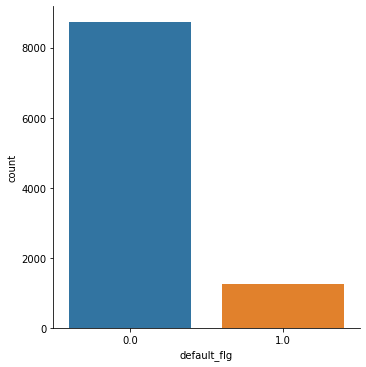

In [25]:
sns.catplot(x="default_flg", kind="count", data=df)


Checking the proportion of 0 and 1 in default flag. We can see this is an unbalanced problem with less than 15% of 1 and 85% of 0s.

Next, we are checking the distribution of different variable across y variable (default flag)

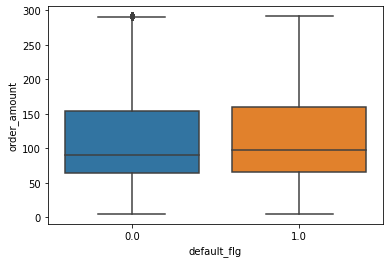

In [26]:
sns.boxplot(x="default_flg", y="order_amount", data=df)

The distribution of order amount is similar across 0 and 1 default flag. This might not be a very good predictor.

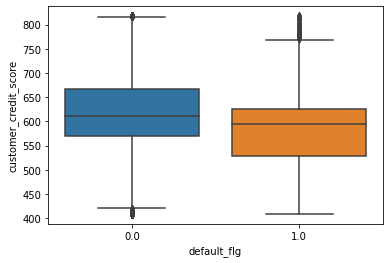

In [27]:
sns.boxplot(x="default_flg", y="customer_credit_score", data=df)


We can see that the credit scores of defaulters are lower than that of non-defaulters. This may come as an important predictor variable.

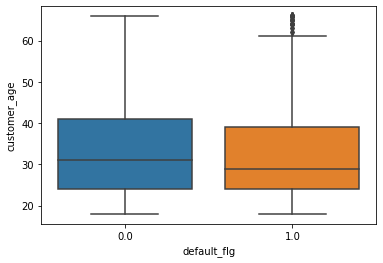

In [28]:
sns.boxplot(x="default_flg", y="customer_age", data=df)


Again, we can see that the customer age for defaulters is slightly lower than that of non-defaulters. This may come as an important predictor variable.

Next, we will see the distribution of each variables.

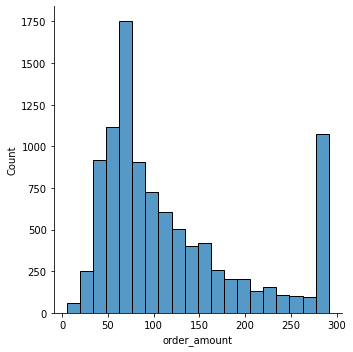

In [29]:
sns.displot(df, x="order_amount",bins=20)

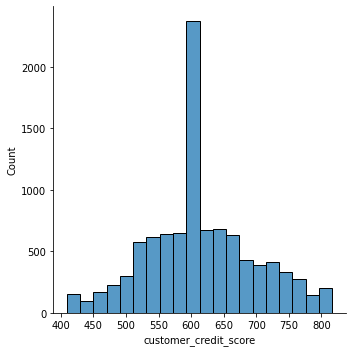

In [30]:
sns.displot(df, x="customer_credit_score",bins=20)

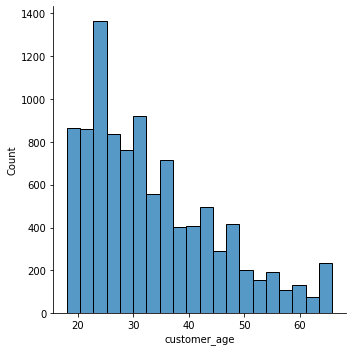

In [31]:
sns.displot(df, x="customer_age",bins=20)

Next, we plot the scatterplot for two variables along with the default flag.

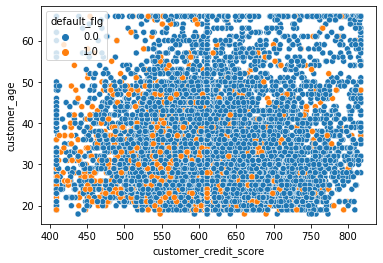

In [32]:
sns.scatterplot(data=df, x="customer_credit_score", y="customer_age", hue="default_flg")


Here, we can see that the defaulters are slightly more concentrated towards the low credit score and low customer age.

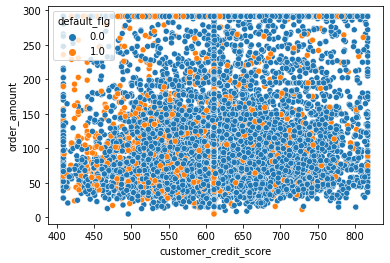

In [33]:
sns.scatterplot(data=df, x="customer_credit_score", y="order_amount", hue="default_flg")


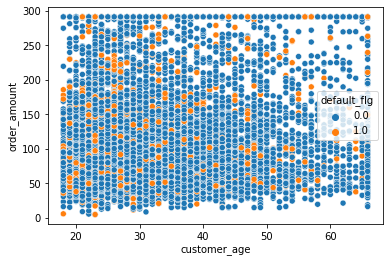

In [34]:
sns.scatterplot(data=df, x="customer_age", y="order_amount", hue="default_flg")


                       order_amount  customer_credit_score  customer_age
order_amount               1.000000               0.157778      0.179910
customer_credit_score      0.157778               1.000000      0.072052
customer_age               0.179910               0.072052      1.000000


[Text(0.5, 0, 'order_amount'),
 Text(1.5, 0, 'customer_credit_score'),
 Text(2.5, 0, 'customer_age')]

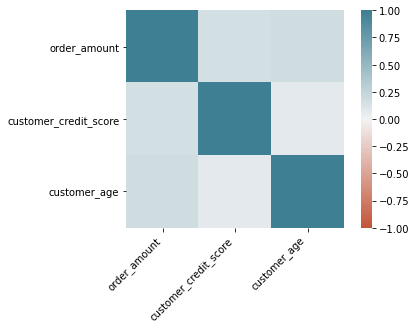

In [35]:
corr_data = df[features]
corr = corr_data.corr()
print(corr)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

There is no high correlation between the three variables

# Variable selection and transformation

### Weight of Evidence (WOE) and Information Value (IV)

In [36]:
def calculate_woe_iv(dataset, feature, target):
    new_var = col+'_bin'
    dataset[new_var] = pd.qcut(dataset[feature], 10, labels = False, duplicates='drop')
    result = dataset.groupby(new_var).agg({col: ['count', 'min', 'max']})
    print(result)
    print('\n')

    lst = []
    for i in range(dataset[new_var].nunique()):
        val = list(dataset[new_var].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[new_var] == val].count()[new_var],
            'Good': dataset[(dataset[new_var] == val) & (dataset[target] == 0)].count()[new_var],
            'Bad': dataset[(dataset[new_var] == val) & (dataset[target] == 1)].count()[new_var]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    dset = dset.sort_values(by='Value')
    return dset, iv



In [37]:
features = ['order_amount', 'customer_credit_score', 'customer_age']
for col in features:
  print('WoE and IV for column: ', col)
  woe_df, iv = calculate_woe_iv(df, col, 'default_flg')
  print(woe_df)
  print('IV score: {:.2f}'.format(iv))
  print('\n')


WoE and IV for column:  order_amount
                 order_amount                
                        count     min     max
order_amount_bin                             
0                        1010    4.95   44.99
1                         990   45.00   58.06
2                        1032   58.11   67.91
3                         965   67.99   75.74
4                         998   75.75   90.74
5                        1004   90.75  109.99
6                         994  110.00  138.59
7                         999  138.60  179.96
8                        1998  179.98  291.50


   Value   All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
7      0  1010   908  102    0.103866   0.081731  0.239675  0.005305
2      1   990   870  120    0.099520   0.096154  0.034405  0.000116
3      2  1032   901  131    0.103066   0.104968 -0.018289  0.000035
1      3   965   855  110    0.097804   0.088141  0.104024  0.001005
5      4   998   887  111    0.101464   0.088942  0.131718  0.00

We can see that the IV value for order_amount is as low as 0.2, and the WOE for different bins are not directional. As such, order_amount may not be a very important predictor.

Customer credit score has a high IV value, and the WOE for different bins are unidirectional as well.

For Customer age, we can create three different bins based on the WOE values.


In [38]:
df['age_less25'] = np.where(df['customer_age']<=25, 1, 0)
df['age_more44'] = np.where(df['customer_age']>=44, 1, 0)   
df['cs_age'] = df['customer_credit_score']*df['age_more44']


We have created the age bins, as well as created a new interaction variable between credit score and age.

# Classification Modelling

### Machine Learning Algorithms

We created a function that takes in input data, predictors, dependent variable and model. It outputs the optimal probability threshold based on f1 score, and calculates the accuracy, recall and precision at the optimal threshold level. It also plots the ROC curve. 

In [39]:
def get_f1_score(y_act, y_probability, p):
  y_pred = np.where(y_probability > p, 1, 0)
  acc_score = accuracy_score(y_act, y_pred)
  rec_score = recall_score(y_act, y_pred)
  prec_score = precision_score(y_act, y_pred)
  fone_score = f1_score(y_act, y_pred)
  cm = confusion_matrix(y_act, y_pred, labels = [0,1])
  return p, acc_score, rec_score, prec_score, fone_score, cm, y_pred

def get_ROC_curve(y_act, y_probability):
  fpr, tpr, thresholds = roc_curve(y_act, y_probability)
  roc_auc = roc_auc_score(y_act, y_probability)
  plt.figure()
  plt.plot(fpr, tpr, label = "area is %.2f" %roc_auc)
  plt.plot([0,1], [0,1], "--r")
  plt.xlim = [0,1.5]
  plt.legend(loc = "lower right")
  plt.title("ROC Curve")

In [40]:
def run_classification_model(data_1, feature_var, target, model, smote_f = False):    
  X_train, X_test, y_train, y_test = train_test_split(data_1[feature_var], data_1[target], test_size=0.3, stratify=data_1[target], random_state = 1)
  if smote_f == True:
    sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=seed)
    X_train, y_train = sm.fit_resample(X_train, y_train)
  model.fit(X_train, y_train)
  y_proba_train = model.predict_proba(X_train)[:,1]
  get_ROC_curve(y_train, y_proba_train)
  opt_f1 = 0
  for i in range(0,100):
    cut_off, acc_sc, recall, precision, f1_sc, cm, y_pred = get_f1_score(y_train, y_proba_train, i/100)
    #print("Threshold: %.2f" %(i/100), "f1 score: %.2f" %f1_sc, "recall: %.2f" %recall, "precision: %.2f" %precision)
    if opt_f1 < f1_sc:
      opt_f1, cut_off_op, recall_op, prc_op, acc_op = f1_sc, cut_off, recall, precision, acc_sc
  print("The optimal cutoff is %.2f" %cut_off_op, "and the corresponding f1-score is %.2f" %opt_f1)
  y_proba_test = model.predict_proba(X_test)[:,1]
  cut_off, acc_score, rec_score, precision_score, f1_score, cm, y_pred = get_f1_score(y_test, y_proba_test, cut_off_op)
  print("Test Accuracy %.2f" %acc_score)
  print("Test Recall %.2f" %rec_score)
  print("Test Precision %.2f" %precision_score)
  print("Test Confusion Matrix")
  print(cm)
  return y_pred, cut_off, cm

The optimal cutoff is 0.13 and the corresponding f1-score is 0.27
Test Accuracy 0.63
Test Recall 0.55
Test Precision 0.18
Test Confusion Matrix
[[1694  929]
 [ 170  204]]


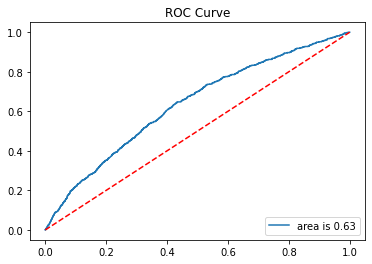

In [41]:
features = ['order_amount', 'customer_credit_score', 'age_less25', 'age_more44']
model = LogisticRegression()
y_pred, cut_off_op, cm = run_classification_model(df, features, 'default_flg', model)

The optimal cutoff is 0.13 and the corresponding f1-score is 0.27
Test Accuracy 0.63
Test Recall 0.55
Test Precision 0.18
Test Confusion Matrix
[[1685  938]
 [ 170  204]]


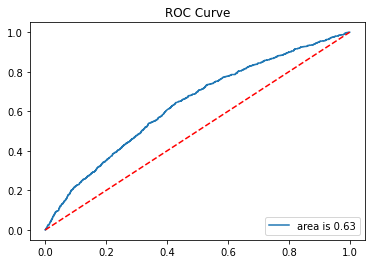

In [42]:
features = ['order_amount', 'customer_credit_score', 'age_less25', 'age_more44', 'cs_age']
model = LogisticRegression()
y_pred, cut_off_op, cm = run_classification_model(df, features, 'default_flg', model)

The optimal cutoff is 0.14 and the corresponding f1-score is 0.27
Test Accuracy 0.69
Test Recall 0.49
Test Precision 0.20
Test Confusion Matrix
[[1882  741]
 [ 191  183]]


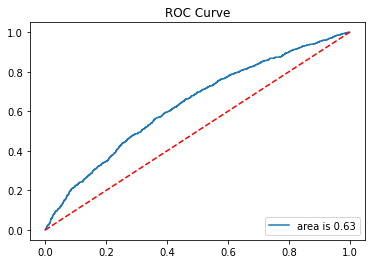

In [43]:
features = ['order_amount', 'customer_credit_score', 'customer_age']
model = LogisticRegression()
y_pred, cut_off_op, cm = run_classification_model(df, features, 'default_flg', model)

The optimal cutoff is 0.17 and the corresponding f1-score is 0.36
Test Accuracy 0.75
Test Recall 0.33
Test Precision 0.20
Test Confusion Matrix
[[2127  496]
 [ 250  124]]


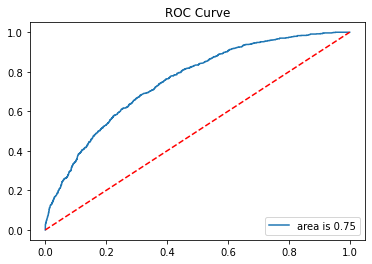

In [44]:
features = ['order_amount', 'customer_credit_score', 'customer_age', 'cs_age']
model = RandomForestClassifier(n_estimators=10, min_samples_split=200)
y_pred, cut_off_op, cm = run_classification_model(df, features, 'default_flg', model)

We have run several models with changes in variables and model selection.
Random Forest gives the best accuracy at 72% with f1 score at 0.36. The Area Under the ROC curve is 0.76  

Derive the feature importance using Random Forest Classifier

In [45]:
def get_feature_importance(data_1, feature_var, target, model):    
  X_train, X_test, y_train, y_test = train_test_split(data_1[feature_var], data_1[target], test_size=0.3, stratify=data_1[target], random_state = 1)
  model.fit(X_train, y_train)
  wts = model.feature_importances_
  fimp = pd.DataFrame({'importance':(wts*100).round(2), 'feature':feature_var})
  print(fimp[fimp['importance']>0].sort_values('importance', ascending=False).reset_index(drop=True))

In [46]:
features = ['order_amount', 'customer_credit_score', 'age_less25', 'age_more44', 'cs_age', 'customer_age']
model = RandomForestClassifier(n_estimators=10, min_samples_split=200)
get_feature_importance(df, features, 'default_flg', model)

   importance                feature
0       42.06  customer_credit_score
1       29.39           order_amount
2       15.06           customer_age
3       11.81                 cs_age
4        1.23             age_less25
5        0.45             age_more44


In [47]:
features = ['order_amount', 'customer_credit_score', 'customer_age']
model = RandomForestClassifier(n_estimators=10, min_samples_split=200)
get_feature_importance(df, features, 'default_flg', model)

   importance                feature
0       46.69  customer_credit_score
1       34.21           order_amount
2       19.10           customer_age


In [48]:
features = ['order_amount', 'customer_credit_score', 'age_less25', 'age_more44']
model = RandomForestClassifier(n_estimators=10, min_samples_split=200)
get_feature_importance(df, features, 'default_flg', model)

   importance                feature
0       52.48  customer_credit_score
1       44.55           order_amount
2        1.73             age_less25
3        1.24             age_more44


We can use the important variables based on the feature importance values in our model to improve the accuracy


### Deep Learning Algorithms

In [49]:
def run_ann(data_1, feature_var, target):
    def reset_random_seeds():
      os.environ['PYTHONHASHSEED']=str(1)
      tf.random.set_seed(1)
      np.random.seed(1)
      random.seed(1)  
    reset_random_seeds() 
    X_train, X_test, y_train, y_test = train_test_split(data_1[feature_var], data_1[target], test_size=0.3, stratify=data_1[target], random_state = 1)
    # Initializing the ANN
    ann = tf.keras.models.Sequential()
    # Adding the input layer and the first hidden layer
    ann.add(tf.keras.layers.Dense(units=60, activation='relu'))
    # Adding the second hidden layer
    ann.add(tf.keras.layers.Dense(units=100, activation='relu'))
    # Adding the output layer
    ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    # Part 3 - Training the ANN
    # Compiling the ANN
    ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    # Training the ANN on the Training set
    ann.fit(X_train, y_train, batch_size = 32, epochs = 100)
    # Part 4 - Making the predictions and evaluating the model
    y_proba = ann.predict(X_test)[:,0]
    print(y_proba)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label = "area is %.2f" %roc_auc)
    plt.plot([0,1], [0,1], "--r")
    plt.xlim = [0,1.5]
    plt.legend(loc = "lower right")
    plt.title("roc curve")

    opt_f1 = 0
    cut_off_op = 0

    for i in range(0,100):
        y_pred = np.where(y_proba<=(i/100),0,1)
        cm = confusion_matrix(y_test, y_pred, labels = [0,1])
        #print(cm)
        recall = recall_score(y_test, y_pred, labels=np.unique(y_pred))
        precision = precision_score(y_test, y_pred, labels=np.unique(y_pred))
        f1_sc = f1_score(y_test, y_pred, labels=np.unique(y_pred))
        #print("Threshold: %.2f" %(i/100), "f1 score: %.2f" %f1_sc, "recall: %.2f" %recall, "precision: %.2f" %precision)
        cut_off= i/100
        if opt_f1 < f1_sc:
            opt_f1 = f1_sc
            cut_off_op = cut_off
    print("The optimal cutoff is %.2f" %cut_off_op, "and the corresponding f1-score is %.2f" %opt_f1)
    y_pred = np.where(y_proba>cut_off_op, 1, 0)

    acc_score = accuracy_score(y_test, y_pred)
    rec_score = recall_score(y_test, y_pred)
    prec_score = precision_score(y_test, y_pred)
    print("Accuracy %.2f" %acc_score)
    print("Recall %.2f" %rec_score)
    print("Precision %.2f" %prec_score)
    return y_proba

Epoch 1/100
219/219 [==============================] - 1s 2ms/step - loss: 0.6072 - accuracy: 0.8457
Epoch 2/100
219/219 [==============================] - 0s 2ms/step - loss: 0.4572 - accuracy: 0.8640
Epoch 3/100
219/219 [==============================] - 0s 2ms/step - loss: 0.4747 - accuracy: 0.8634
Epoch 4/100
219/219 [==============================] - 0s 2ms/step - loss: 0.4596 - accuracy: 0.8607
Epoch 5/100
219/219 [==============================] - 0s 2ms/step - loss: 0.4538 - accuracy: 0.8600
Epoch 6/100
219/219 [==============================] - 0s 2ms/step - loss: 0.4366 - accuracy: 0.8597
Epoch 7/100
219/219 [==============================] - 0s 2ms/step - loss: 0.4675 - accuracy: 0.8569
Epoch 8/100
219/219 [==============================] - 0s 2ms/step - loss: 0.4607 - accuracy: 0.8557
Epoch 9/100
219/219 [==============================] - 0s 2ms/step - loss: 0.4029 - accuracy: 0.8730
Epoch 10/100
219/219 [==============================] - 0s 2ms/step - loss: 0.4390 - accura

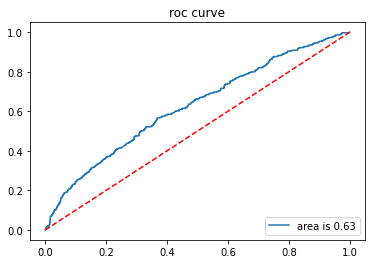

In [50]:
y_proba = run_ann(df, features, 'default_flg')

We have also run a neural network model, but the result has not improved much, compared to the Machine Learning algorithms done above.
We will need more data/varibles as our next steps to leverage the ANN algorithm and thus improve the accuracy.

# SMOTE: Synthetic Minority Oversampling TEchnique
Smote is used to solve the problem of unbalanced problem by synthetically generating data for class with lower population. 

In [51]:
features = ['order_amount', 'customer_credit_score', 'customer_age']
from imblearn.over_sampling import SMOTE
seed = 100
X = df[features]
y = df['default_flg']
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=seed)
X, y = sm.fit_resample(X, y)
df1 = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1)
df1.columns = ['order_amount', 'customer_credit_score', 'customer_age', 'default_flg']

Distribution of response variable post application of SMOTE

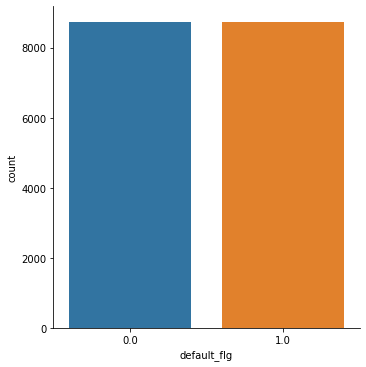

In [52]:
import seaborn as sns
sns.catplot(x="default_flg", kind="count", data=df1)


Re-execution of Machine Learning algorithms on synthetically balanced data

The optimal cutoff is 0.31 and the corresponding f1-score is 0.67
Test Accuracy 0.21
Test Recall 0.95
Test Precision 0.13
Test Confusion Matrix
[[ 273 2350]
 [  18  356]]


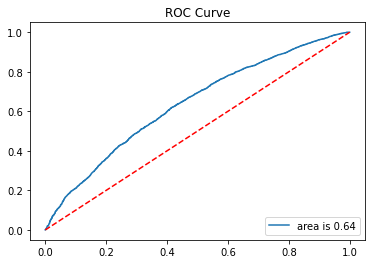

In [53]:
features = ['order_amount', 'customer_credit_score', 'customer_age', 'cs_age']
model = LogisticRegression()
y_pred, cut_off_op, cm = run_classification_model(df, features, 'default_flg', model, smote_f=True)

The optimal cutoff is 0.29 and the corresponding f1-score is 0.67
Test Accuracy 0.19
Test Recall 0.96
Test Precision 0.13
Test Confusion Matrix
[[ 210 2413]
 [  15  359]]


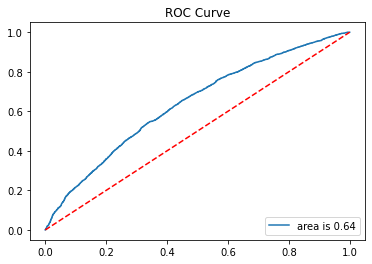

In [54]:
features = ['order_amount', 'customer_credit_score', 'customer_age']
model = LogisticRegression()
y_pred, cut_off_op, cm = run_classification_model(df, features, 'default_flg', model, smote_f=True)

The optimal cutoff is 0.43 and the corresponding f1-score is 0.77
Test Accuracy 0.56
Test Recall 0.58
Test Precision 0.16
Test Confusion Matrix
[[1475 1148]
 [ 157  217]]


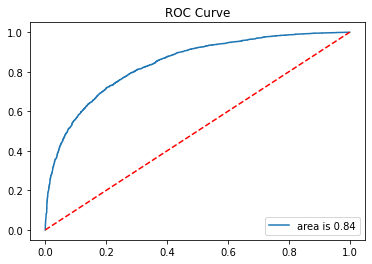

In [55]:
features = ['order_amount', 'customer_credit_score', 'customer_age']
model = RandomForestClassifier(n_estimators=10,  min_samples_split=200)
y_pred, cut_off_op, cm = run_classification_model(df, features, 'default_flg', model, smote_f=True)

Using Smote we see the result is slightly improving, but we will require more attributes to capture the differentiating pattern well

### Assumptions & observations in data
*   The solution has been modulated at a order level given the fact that there are 8932 customers for 10000 orders. The reason is that there is very less data at an customer level
*   We have discarded 'checkout_started_at', 'credit_decision_started_at', 'approved_for_installments', 'customer_billing_zip', 'customer_shipping_zip' as these variables have hardly any variability or too much variability
*   There is limitation of the data; more data are required to capture the trend which will able to clearly seperate the default from the non-default orders
*   There are duplicates in order data, we have discarded the duplicates order data based on our little understanding of the data
*   We found the 'customer_credit_score' variable has a high predicting power





###Next Steps:

*   We will need more relevant variables (order and customer attributes) which can better capture whether an order will be defaulted or not. 
*   Hyperparameter tuning and variable transformation can be done to increase the accuracy of the models
*   We can rebuild the pipeline by redefining the reponse variable as - if any of the first three installments is missed we can still consider the order as non-default given the latest installment is paid on time.
*   We might want to give more weight to precision over recall or vice versa depending on the business need
